In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import Markdown, display


def printmd(string):
    display(Markdown(string))


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)

%matplotlib inline
sns.set_style("darkgrid")
%load_ext lab_black

## Generate a time-series data

In [2]:
time = np.arange(1200, dtype="float32")
baseline = 20


def trend(time, slope, intercept=0):
    """Add trend to the data"""
    return time * slope + intercept


def seasonality(time, period, offset=0):
    """Add seasonality to the data"""
    season_time = (time + offset) % period
    return np.where(
        season_time / period < 0.5,
        np.cos(season_time / period * 2 * np.pi) - 10,
        -1 / 3 * season_time + 10,
    )


def noise(time, amplitude, seed=42):
    """Add noise to the data"""
    rnd = np.random.RandomState(seed=seed)
    return rnd.randn(len(time)) * amplitude

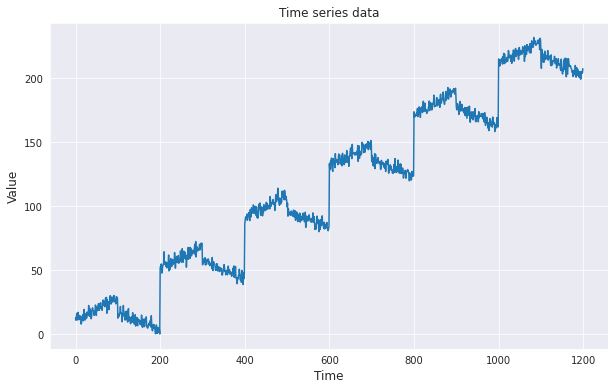

In [3]:
ts = baseline + seasonality(time, 200) + trend(time, 0.2) + noise(time, 3)
plt.figure(figsize=(10, 6))
plt.plot(time, ts)
plt.title("Time series data")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

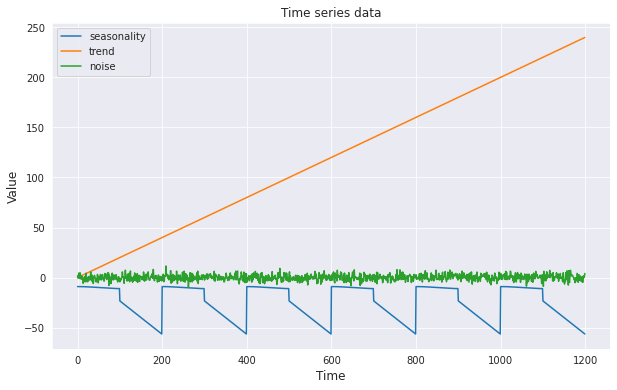

In [5]:
# ts = baseline + seasonality(time, 200) + trend(time, 0.2) + noise(time, 3)
plt.figure(figsize=(10, 6))
plt.plot(time, seasonality(time, 200), label="seasonality")
plt.plot(time, trend(time, 0.2), label="trend")
plt.plot(time, noise(time, 3), label="noise")
plt.title("Time series data")
plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

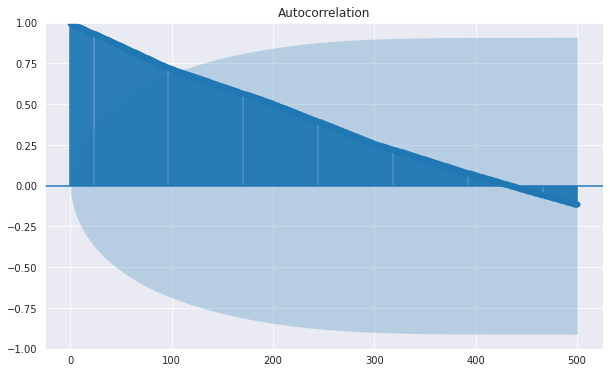

In [104]:
# Autocorrelation grpah

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(ts, lags=500, ax=ax)
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


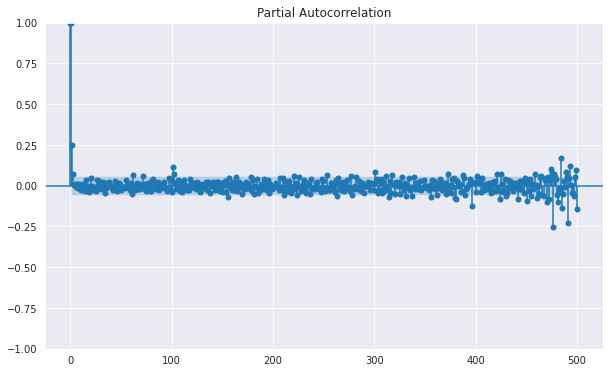

In [105]:
# partial Autocorrelation grpah

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(ts, lags=500, ax=ax)
plt.show()

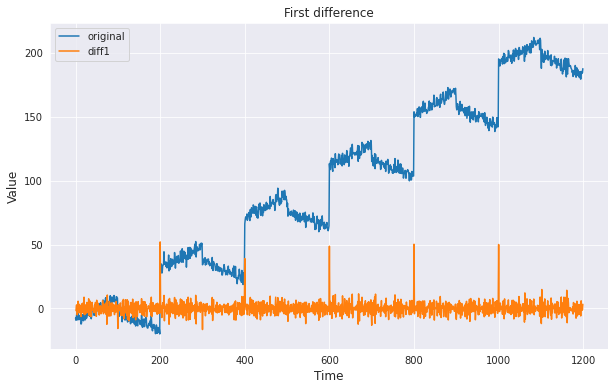

In [4]:
# First difference

ts_diff1 = ts[1:] - ts[:-1]
plt.figure(figsize=(10, 6))
plt.plot(time, ts, label="original")
plt.plot(time[1:], ts_diff1, label="diff1")
plt.title("First difference")
plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

## Visualizations

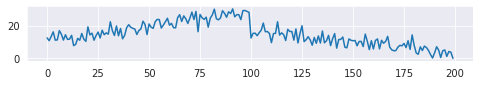

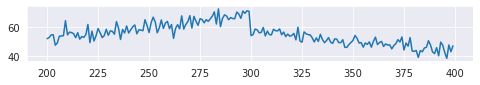

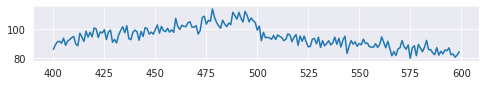

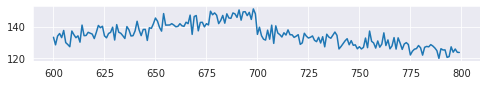

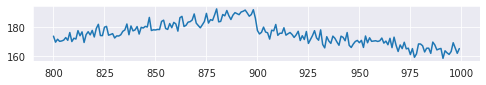

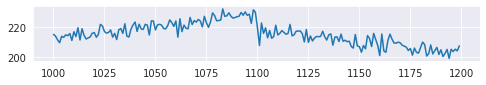

In [52]:
# seasonal linear plot

for i in range(0, 1200, 200):
    plt.figure(figsize=(8, 1))
    plt.plot(time[i : i + 200], ts[i : i + 200], label="original")
    plt.show()

<AxesSubplot:ylabel='Density'>

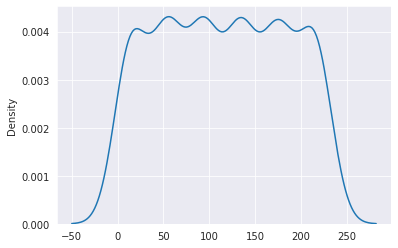

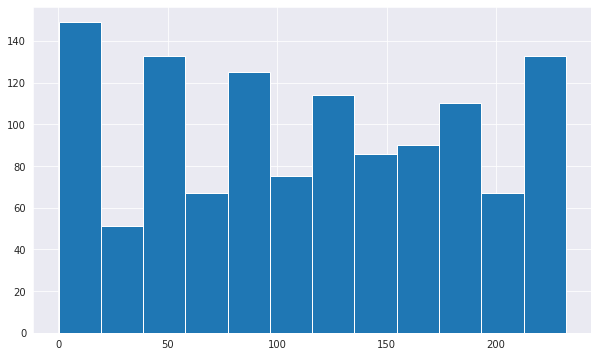

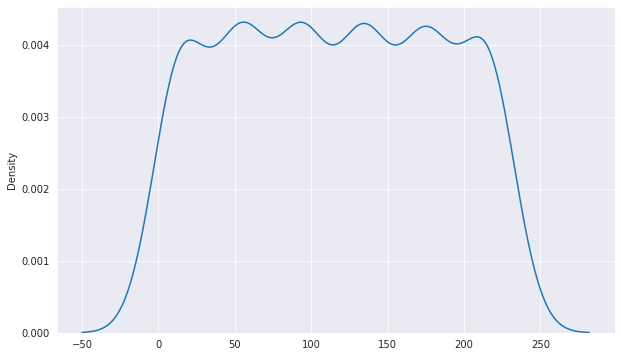

In [58]:
# density plot

plt.figure(figsize=(10, 6))
plt.hist(ts, bins="auto")
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(ts)
plt.show()

## Different transformation

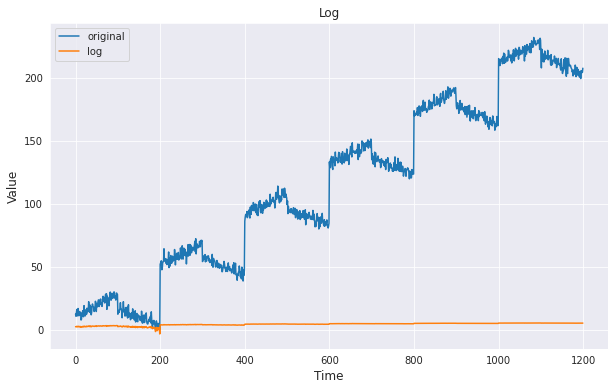

In [31]:
# Log transformation

logts = np.log(ts)
plt.figure(figsize=(10, 6))
plt.plot(time, ts, label="original")
plt.plot(time, logts, label="log")
plt.title("Log")
plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

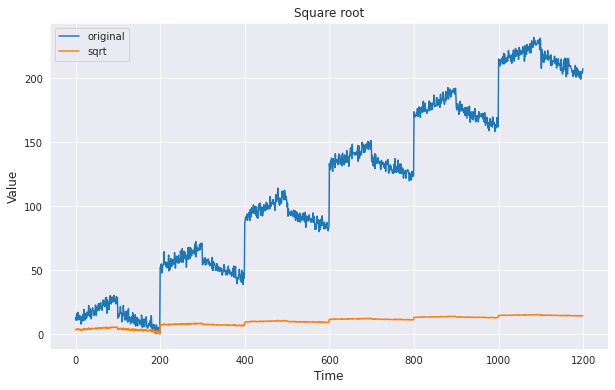

In [32]:
# square root transformation

logts = np.sqrt(ts)
plt.figure(figsize=(10, 6))
plt.plot(time, ts, label="original")
plt.plot(time, logts, label="sqrt")
plt.title("Square root")
plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

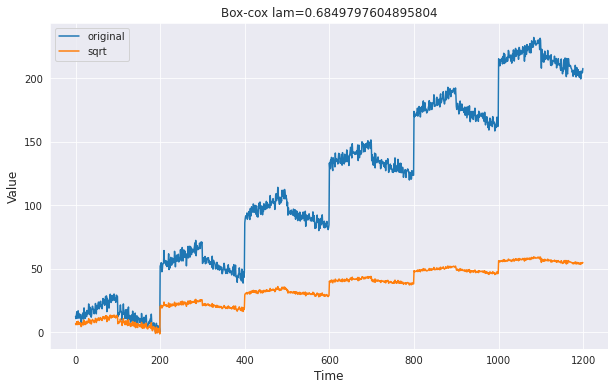

In [33]:
# Box-cox transformation

boxcox_ts, lam = boxcox(ts)
plt.figure(figsize=(10, 6))
plt.plot(time, ts, label="original")
plt.plot(time, boxcox_ts, label="sqrt")
plt.title(f"Box-cox lam={lam}")
plt.legend()
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

## Stationality test

In [4]:
def test_stationarity(timeseries, window=12):
    rolmean = timeseries.rolling(window=window, center=False).mean()
    rolstd = timeseries.rolling(window=window, center=False).std()
    plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")  # 设置原始图，移动平均图和标准差图的式样
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")  # 使用自动最佳的图例显示位置
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()  # 供肉眼观察是否平稳
    print("ADF检验结果：")
    dftest = adfuller(timeseries, autolag="AIC")  # 使用减小AIC的办法估算ADF测试所需的滞后数
    # 将ADF测试结果、显著性概率、所用的滞后数和所用的观测数打印出来
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Num Lags Used", "Num Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

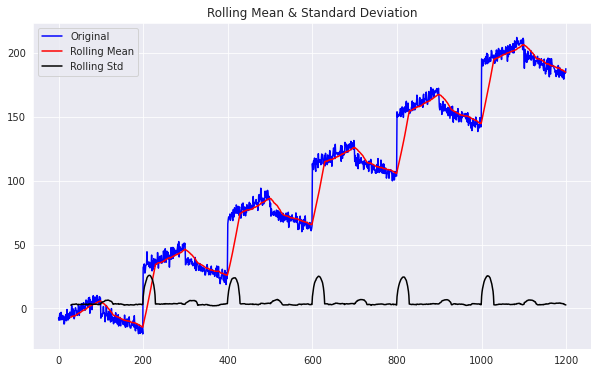

ADF检验结果：
Test Statistic             -0.984565
p-value                     0.758852
Num Lags Used               2.000000
Num Observations Used    1197.000000
Critical Value (1%)        -3.435825
Critical Value (5%)        -2.863958
Critical Value (10%)       -2.568057
dtype: float64


In [22]:
ts_df = pd.DataFrame()
ts_df["ts"] = ts
test_stationarity(ts_df["ts"], window=30)

## Decompose the series

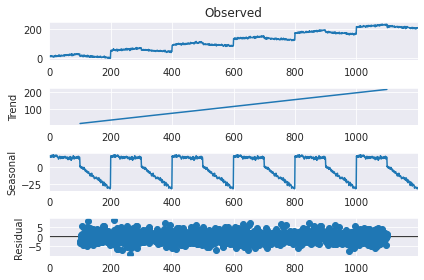

In [6]:
result = seasonal_decompose(ts, model="additive", period=200)
result.plot()
plt.show()

---

## Training and validation split

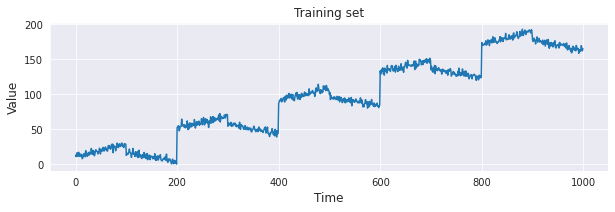

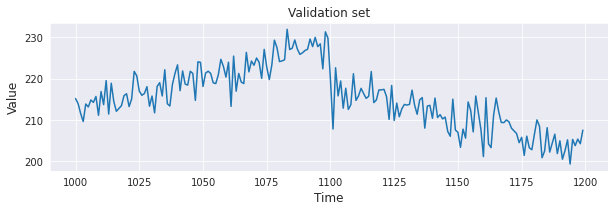

In [8]:
split_time = 1000
trn = ts[:split_time]
val = ts[split_time:]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:split_time], trn)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Training set")
plt.show()
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 2)
plt.plot(time[split_time:], val)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Validation set")
plt.show()

---

## Naive prediction

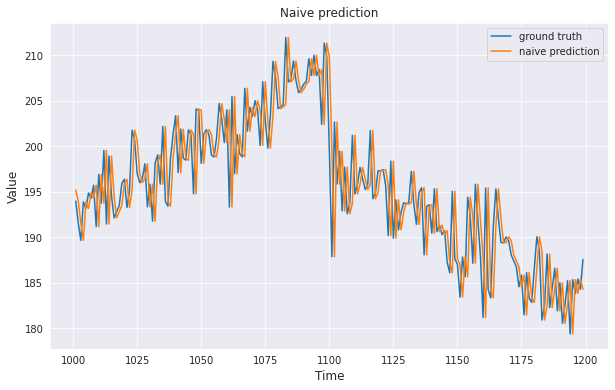

Mean squared error: 21.093

Mean absolute error: 3.543

In [17]:
n_p = ts[split_time - 1 : -1]

plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(time[split_time:], n_p, label="naive prediction")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, np),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, np),3)}")

## Autoregression

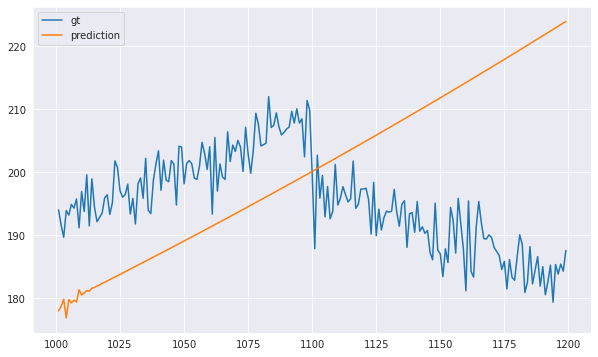

Mean squared error: 367.627

Mean absolute error: 16.403

In [54]:
# Naive AR
ar = AutoReg(trn, lags=10, trend="n", seasonal=False, period=None)
ar_fit = ar.fit()

pred = ar_fit.predict(start=len(trn), end=len(ts) - 1)

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

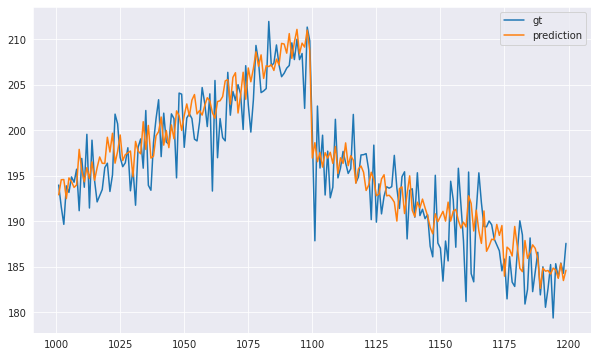

Mean squared error: 12.107

Mean absolute error: 2.796

In [99]:
# AR with trend + sensonality
ar = AutoReg(trn, lags=5, trend="c", seasonal=True, period=200)
ar_fit = ar.fit()

pred = ar_fit.predict(start=len(trn), end=len(ts) - 1)

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

In [100]:
ar_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 1001
Model:               Seas. AutoReg(5)   Log Likelihood               -2469.356
Method:               Conditional MLE   S.D. of innovations              2.887
Date:                Fri, 18 Mar 2022   AIC                           5350.712
Time:                        09:31:42   BIC                           6360.884
Sample:                             5   HQIC                          5734.722
                                 1001                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.2443      1.296     37.213      0.000      45.703      50.785
s(2,200)     -11.3074      2.429     -4.654      0.000     -16.069      -6.546
s(3,200)     -18.2549      2.631     -6.937      0.000     -23.412     -13.098
s(4,200)     -27.2619      2.638    -10.335      0.000     -32.432     -22.092
s(5,200)     -37.9159      2.445    -15.508      0.000     -42.708     -33.124
s(6,200)     -47.4816      1.830    -25.948      0.000     -51.068     -43.895
s(7,200)     -47.6497      1.829    -26.056      0.000     -51.234     -44.065
s(8,200)     -48.6632      1.831    -26.585      0.000     -52.251     -45.075
s(9,200)     -48.2809      1.828    -26.418      0.000     -51.863     -44.699
s(10,200)    -44.0681      1.828    -24.107      0.000     -47.651     -40.485
s(11,200)    -47.6475      1.830    -26.035      0.000     -51.234     -44.060
s(12,200)    -49.0123      1.832    -26.750      0.000     -52.604     -45.421
s(13,200)    -47.3677      1.829    -25.899      0.000     -50.952     -43.783
s(14,200)    -48.8788      1.830    -26.705      0.000     -52.466     -45.291
s(15,200)    -47.4765      1.830    -25.942      0.000     -51.063     -43.890
s(16,200)    -49.1783      1.827    -26.924      0.000     -52.758     -45.598
s(17,200)    -47.4401      1.830    -25.926      0.000     -51.026     -43.854
s(18,200)    -46.6951      1.826    -25.569      0.000     -50.274     -43.116
s(19,200)    -47.5163      1.830    -25.969      0.000     -51.103     -43.930
s(20,200)    -48.0140      1.828    -26.264      0.000     -51.597     -44.431
s(21,200)    -44.9395      1.828    -24.586      0.000     -48.522     -41.357
s(22,200)    -47.5504      1.829    -25.997      0.000     -51.135     -43.965
s(23,200)    -45.9041      1.830    -25.082      0.000     -49.491     -42.317
s(24,200)    -49.6725      1.828    -27.167      0.000     -53.256     -46.089
s(25,200)    -48.2510      1.832    -26.331      0.000     -51.843     -44.659
s(26,200)    -46.9003      1.827    -25.671      0.000     -50.481     -43.320
s(27,200)    -49.6411      1.831    -27.113      0.000     -53.230     -46.053
s(28,200)    -49.0061      1.830    -26.774      0.000     -52.594     -45.419
s(29,200)    -48.1258      1.827    -26.335      0.000     -51.708     -44.544
s(30,200)    -48.1527      1.830    -26.318      0.000     -51.739     -44.567
s(31,200)    -51.1902      1.828    -28.006      0.000     -54.773     -47.608
s(32,200)    -46.2091      1.829    -25.260      0.000     -49.795     -42.624
s(33,200)    -47.7385      1.828    -26.118      0.000     -51.321     -44.156
s(34,200)    -48.1369      1.832    -26.273      0.000     -51.728     -44.546
s(35,200)    -44.6805      1.828    -24.444      0.000     -48.263     -41.098
s(36,200)    -48.1113      1.833    -26.243      0.000     -51.705     -44.518
s(37,200)    -46.2757      1.832    -25.266      0.000     -49.865     -42.686
s(38,200)    -50.1765      1.828    -27.447      0.000     -53.760     -46.594
s(

## Moving average

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


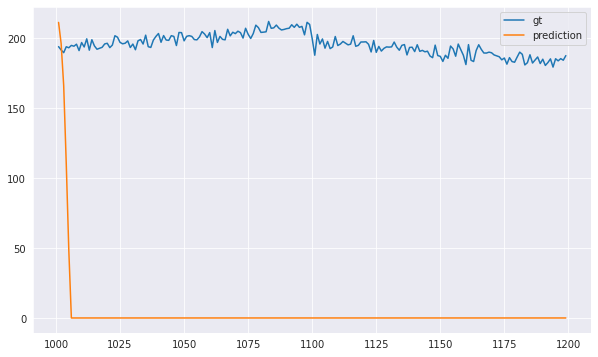

Mean squared error: 37446.282

Mean absolute error: 191.931

In [62]:
# Naive MA
arima = ARIMA(
    trn,
    order=(0, 0, 5),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=False,
)
arima_fit = arima.fit()

pred = arima_fit.predict(start=len(trn), end=len(ts) - 1)

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

In [98]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1001
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -3039.503
Date:                Fri, 18 Mar 2022   AIC                           6101.006
Time:                        09:30:55   BIC                           6154.925
Sample:                             0   HQIC                          6121.505
                               - 1001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3670      4.080     -0.090      0.928      -8.364       7.630
ar.L2         -0.4411      3.593     -0.123      0.902      -7.484       6.602
ar.L3         -0.0639      3.985     -0.016      0.987      -7.874       7.747
ar.L4          0.2663      2.367      0.113      0.910      -4.372       4.905
ar.L5          0.0083      0.361      0.023      0.982      -0.700       0.717
ma.L1          0.0149      4.080      0.004      0.997      -7.982       8.011
ma.L2          0.3236      2.185      0.148      0.882      -3.958       4.605
ma.L3         -0.0599      2.784     -0.022      0.983      -5.516       5.396
ma.L4         -0.3446      1.161     -0.297      0.767      -2.620       1.931
ma.L5          0.1296      0.688      0.188      0.851      -1.219       1.478
sigma2        26.4695      0.358     74.028      0.000      25.769      27.170
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             60628.94
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             4.07
Prob(H) (two-sided):                  0.03   Kurtosis:                        40.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


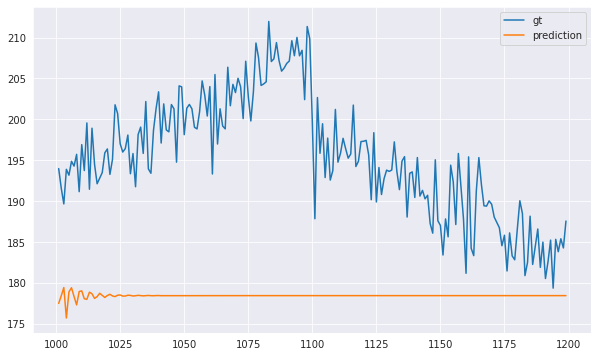

Mean squared error: 342.538

Mean absolute error: 16.963

In [97]:
# ARIMA without trend & seasonality
arima = ARIMA(
    trn,
    order=(5, 1, 5),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=False,
)
arima_fit = arima.fit()

pred = arima_fit.predict(start=len(trn), end=len(ts) - 1)

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

## Moving average smoothing (self-implementation)

In [144]:
def moving_average(ts, window_size):
    ma = []
    for i in range(len(ts) - window_size):
        ma.append(ts[i : i + window_size].mean())
    return ma


def moving_average_forcast(ts, window_size, nof_value):
    for i in range(nof_value):
        ts = np.append(ts, ts[-window_size:].mean())
    return ts

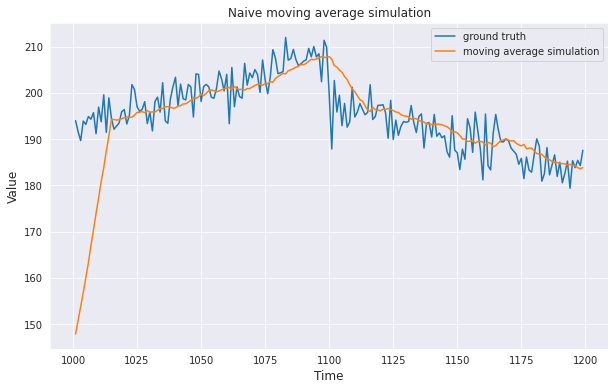

In [134]:
window_size = 15
ma = moving_average(ts, window_size)
plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(
    time[split_time:], ma[split_time - window_size :], label="moving average simulation"
)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive moving average simulation")
plt.legend()
plt.show()

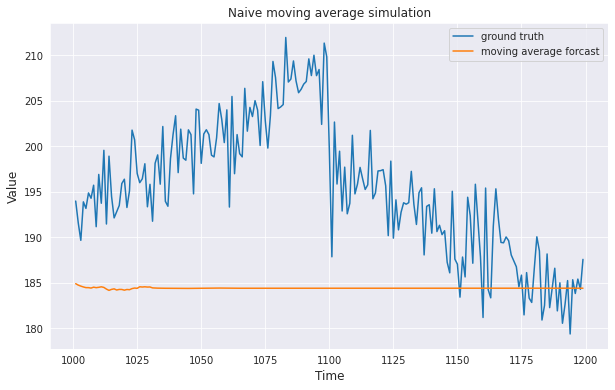

In [142]:
window_size = 30
# ma = moving_average(ts, window_size)
map_ = moving_average_forcast(ts, window_size, 199)
plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(time[split_time:], map_[-199:], label="moving average forcast")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive moving average simulation")
plt.legend()
plt.show()

## ARIMA

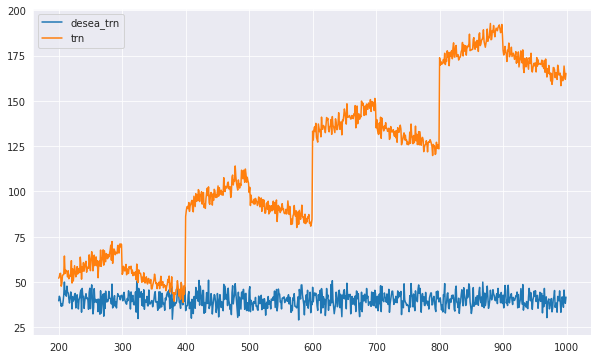

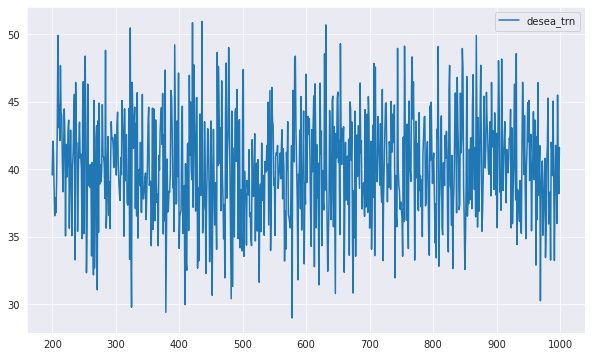

In [81]:
# remove seasonality pattern on training set

period = 200
trn_desea = trn[period:] - trn[:-period]

plt.figure(figsize=(10, 6))

plt.plot(time[period:split_time], trn_desea, label="desea_trn")
plt.plot(time[period:split_time], trn[period:], label="trn")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time[period:split_time], trn_desea, label="desea_trn")
plt.legend()
plt.show()

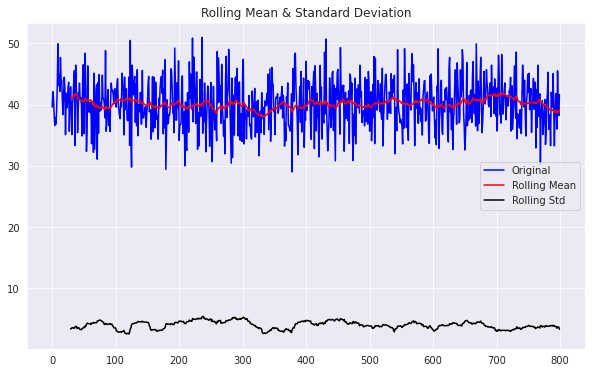

ADF检验结果：
Test Statistic           -28.623168
p-value                    0.000000
Num Lags Used              0.000000
Num Observations Used    799.000000
Critical Value (1%)       -3.438561
Critical Value (5%)       -2.865164
Critical Value (10%)      -2.568700
dtype: float64


In [93]:
# ADF test on de_sea

trn_desea_df = pd.DataFrame()
trn_desea_df["ts"] = trn_desea
trn_desea_df["ts"].astype("float32")
test_stationarity(trn_desea_df["ts"], window=30)

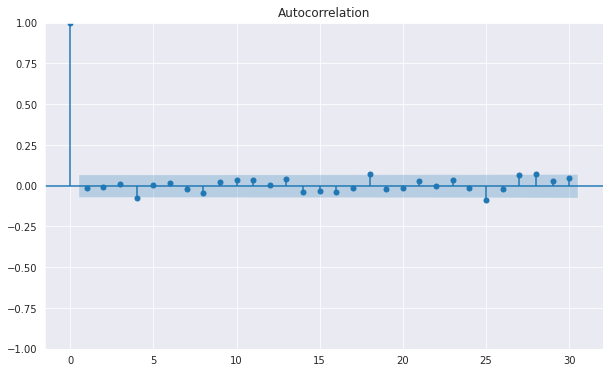

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


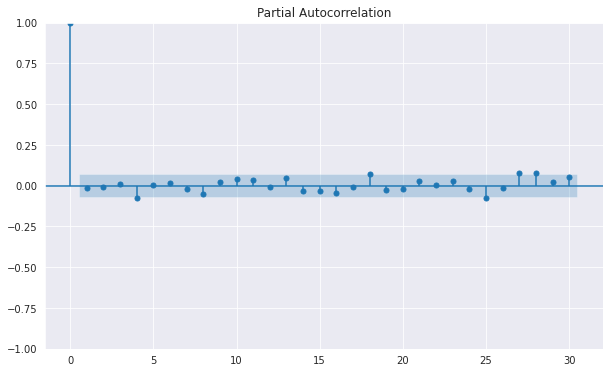

In [95]:
# ACF & PACF

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(trn_desea, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(trn_desea, ax=ax)
plt.show()

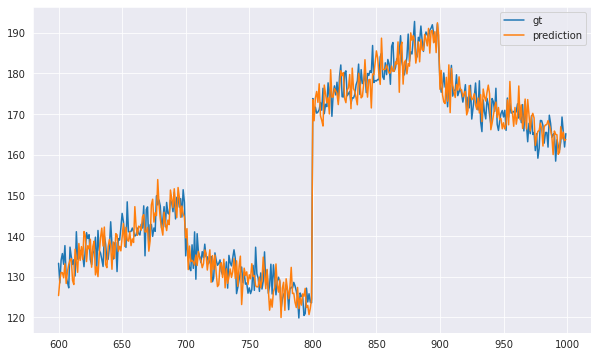

Mean squared error: 15.819

Mean absolute error: 3.257

In [138]:
# Start with (1,0,1) on training set

# period = 200
# trn_desea = trn[period:] - trn[:-period]

size = trn_desea.shape[0]
trn_, test_ = trn_desea[0 : int(size * 0.5)], trn_desea[int(size * 0.5) :]
trn_size, test_size = trn_.shape[0], test_.shape[0]

history = [x for x in trn_]
pred = []

# walk-forward validation
for i in range(test_.shape[0]):

    arima = ARIMA(
        history,
        order=(1, 0, 1),
        seasonal_order=(0, 0, 0, 0),
        trend="n",
        enforce_stationarity=False,
    )
    arima_fit = arima.fit()

    y_ = arima_fit.forecast()[0]
    y_ += trn[trn_size + i]
    pred.append(y_)
    history.append(test_[i])

plt.figure(figsize=(10, 6))

plt.plot(time[600:1000], trn[600:1000], label="gt")
plt.plot(time[600:1000], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(trn[600:1000], pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(trn[600:1000], pred),3)}")

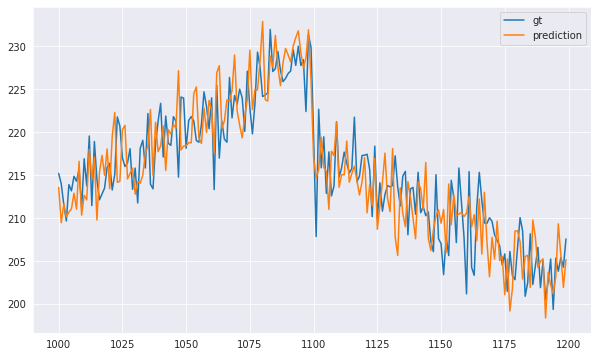

Mean squared error: 15.971

Mean absolute error: 3.296

In [147]:
# Run the ARIMA model on test set

split_time = 1000
trn = ts[:split_time]
val = ts[split_time:]

period = 200
trn_desea = trn[period:] - trn[:-period]

size = trn_desea.shape[0]

history = [x for x in trn_desea]
pred = []

# walk-forward validation
for i in range(val.shape[0]):

    arima = ARIMA(
        history,
        order=(1, 0, 1),
        seasonal_order=(0, 0, 0, 0),
        trend="n",
        enforce_stationarity=False,
    )
    arima_fit = arima.fit()

    y_ = arima_fit.forecast()[0]
    y_ += ts[split_time - period + i]
    pred.append(y_)
    history.append(ts[split_time + i] - ts[split_time - period + i])

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

## SARIMA

In [5]:
result = seasonal_decompose(ts, model="additive", period=200)
seasonal = result.seasonal

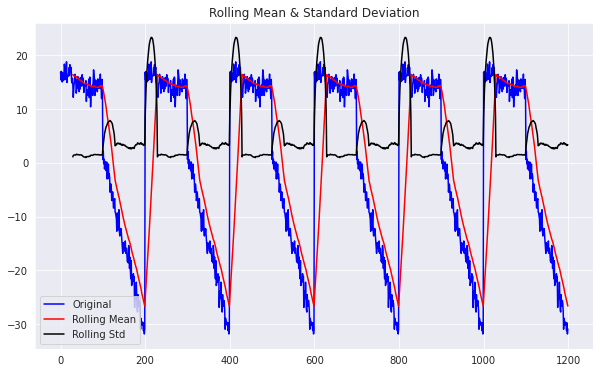

ADF检验结果：
Test Statistic             -3.352780
p-value                     0.012678
Num Lags Used               3.000000
Num Observations Used    1196.000000
Critical Value (1%)        -3.435829
Critical Value (5%)        -2.863960
Critical Value (10%)       -2.568058
dtype: float64


In [6]:
# Check the stationarity of the seasonal component

seasonal_df = pd.DataFrame()
seasonal_df["ts"] = seasonal
test_stationarity(seasonal_df["ts"], window=30)

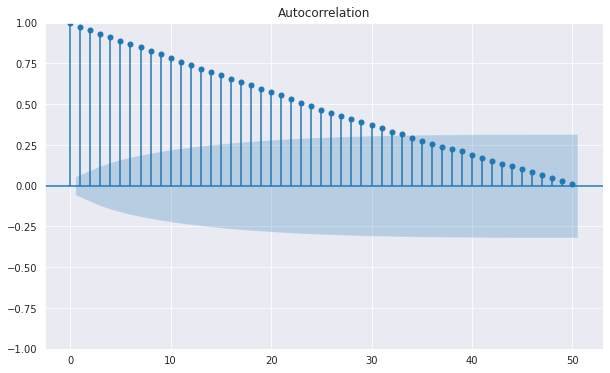

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


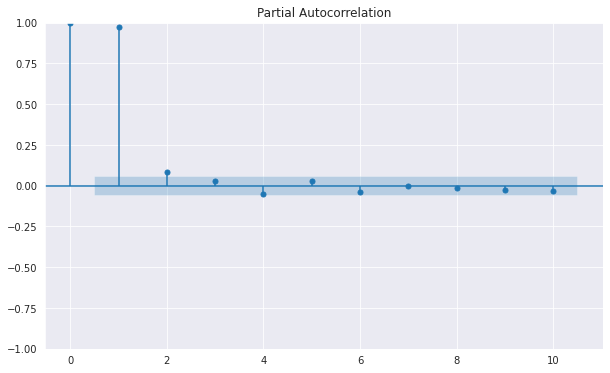

In [158]:
# Autocorrelation grpah

fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_acf(seasonal, lags=50, ax=ax)
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
sm.graphics.tsa.plot_pacf(seasonal, lags=10, ax=ax)
plt.show()

In [ ]:
# SARIMA
arima = ARIMA(
    trn,
    order=(3, 1, 2),
    seasonal_order=(1, 0, 3, 200),
    trend="n",
    enforce_stationarity=False,
)
arima_fit = arima.fit()

pred = arima_fit.predict(start=len(trn), end=len(ts) - 1)

plt.figure(figsize=(10, 6))

plt.plot(time[split_time:], val, label="gt")
plt.plot(time[split_time:], pred, label="prediction")
plt.legend()
plt.show()

printmd(f"Mean squared error: {round(mean_squared_error(val, pred),3)}")
printmd(f"Mean absolute error: {round(mean_absolute_error(val, pred),3)}")

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
